In [ ]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import glob
from PIL import Image as im 

# Stereo Correspondences

## 1.1 Intensity window-based correlation 

function    <font color=blue>__get_points__</font>


 -  **Task** : Gives the points from the patches which has highest correlation
 -  **Working**: Takes two images and patch size:
     - If the images are not dvisible w.r.t patch size. Resize the images
     - Consider one patch in 1st image and for each patch in 2ns image calculates correlation between them and stores the points from the patch which has hightest correlartion with the patch in 1st image
     - Repeats the above steps for every patch in image1
     - return the correlation, corresponding points of patches in each image
 -  **Input** : Two images and the patch size
 -  **Output** : correlation, corresponding points of patches in each image

In [ ]:
def get_points(img1,img2,m):
    rows,cols,p = img1.shape
        
    ans = []
    
    for i1 in range(0,rows-m,m//4):
        for j1 in range(0,cols-m,m//4):
            min_val = 0
            for i2 in range(0,rows-m,m//4):
                for j2 in range(0,cols-m,m//4):
                    t = (img1[i1:i1+m,j1:j1+m].flatten())
                    w = (img2[i2:i2+m,j2:j2+m].flatten())
                    if(len(t)==0 or len(w)==0):
                        pass
                    else:
                        c = np.corrcoef(t, w)
                        if(c[0][1]>min_val):
                            min_val = c[0][1]
                            t1 = [i1+m//2,cols+i2+m//2]
                            w1 = [j1+m//2,j2+m//2]
                            ans.append([c[0][1],t1,w1])
            
    return [ans,img1,img2]


function    <font color=blue>__drawLinesInImages__</font>


 -  **Task** : Given two images ans points it will plot the points in those images
 -  **Working**: Concatenates the given images horizontally and plots in the points in the resultant image
 -  **Input** : Two images and their corresponding points in those images and the number of points to be plotted
 -  **Output** : Plots the resultant images after drawing the lines

In [ ]:
def drawLinesInImages(img1,img2,ans,points):
    indexes = random.sample(range(0, len(ans)), points)
    im_h = cv2.hconcat([img1, img2])
    for a in indexes:
        plt.plot(ans[a][0],ans[a][1])
    plt.imshow(im_h)
    plt.figure(figsize=(10,10))
    plt.show()

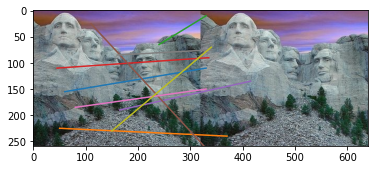

<Figure size 720x720 with 0 Axes>

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
img1 = cv2.imread('../images/Stereo Correspondence/1_1.jpg')  
img2 = cv2.imread('../images/Stereo Correspondence/1_2.jpg') 

ans,img1,img2 = get_points(img1,img2,20)
ans = np.array(ans)
x = np.concatenate((ans[:,[1]],ans[:,[2]]),axis=1)
drawLinesInImages(img1,img2,x,10)

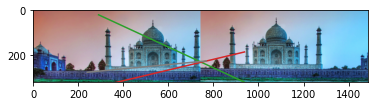

<Figure size 720x720 with 0 Axes>

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
img1 = cv2.imread('../images/Stereo Correspondence/2_1.png')  
img2 = cv2.imread('../images/Stereo Correspondence/2_2.png') 
img1 = cv2.resize(img1, (img2.shape[1], img2.shape[0]))
ans,img1,img2 = get_points(img1,img2,20)
ans = np.array(ans)
x = np.concatenate((ans[:,[1]],ans[:,[2]]),axis=1)
drawLinesInImages(img1,img2,x,10)

In [ ]:
## Attempted it but took time for execution 





# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
# img1 = cv2.imread('../images/Stereo Correspondence/3_1.jpg')  
# img2 = cv2.imread('../images/Stereo Correspondence/3_2.jpg') 

# ans,img1,img2 = get_points(img1,img2,20)
# ans = np.array(ans)
# x = np.concatenate((ans[:,[1]],ans[:,[2]]),axis=1)
# drawLinesInImages(img1,img2,x,10)

## 1.2 Plotting epipolar lines

function    <font color=blue>__get_key_points__</font>


 -  **Task** : To find keypoints and descriptors
 -  **Working**: Uses SIFT and gets the keypoints and descriptors for the image
 -  **Input** : image
 -  **Output** : root mean squared error

In [ ]:
def get_key_points(sift, img1):

    kp1, des1 = sift.detectAndCompute(img1,None)
    
    return [kp1,des1]

function    <font color=blue>__get_matches__</font>


 -  **Task** : Get the matching points from the keypoints and descriptors
 -  **Working**: Given keypoints and descriptors 
     - Uses FlannBasedMatcher and Knn algorithm to get matches
     - enumerate the matches and get the points 
 -  **Input** : Keypoints and descriptors 
 -  **Output** : Points 

In [ ]:
def get_matches(kp1,kp2,des1,des2):

    flann = cv2.FlannBasedMatcher({'algorithm':0, 'trees':5}, {'checks':50})

    matches = flann.knnMatch(des1,des2,k=2)
    pts1,pts2,good=[],[],[]

    for i,(p,q) in enumerate(matches):
        if p.distance<0.75*q.distance:
            good.append(p)
            pts1.append(kp1[p.queryIdx].pt)
            pts2.append(kp2[p.trainIdx].pt)

    return [pts1,pts2]

function    <font color=blue>__find_fundamental_matrix__</font>

 -  **Task** : Calculates the fundamental matrix
 -  **Working**: Takes the source points and destination points. Construct G matrix using the formula
    $ [X1_i*X2_i, X1_i*Y2_i, X1_i, Y1_i*X2_i, Y1_i*Y2_i, Y1_i, X2_i, Y2_i, 1] $
        - Requires minimum of 8 points 
        - Uses singular value decomposition to get the matrix
 -  **Input** : Source_points and destination_points 
 -  **Output** : Fundamental matrix

In [ ]:
def find_fundamental_matrix(src,dest):
    G = []
    for i in range(len(src)):
        temp = [src[i][0]*dest[i][0],src[i][0]*dest[i][1],src[i][0],src[i][1]*dest[i][0],src[i][1]*dest[i][1],src[i][1],dest[i][0],dest[i][1],1]
        G.append(temp)

    matrix = np.linalg.svd(G)
    
    matrix = matrix[-1][-1]
    F = [matrix[0:3],matrix[3:6],matrix[6:9]]
    F = F/F[-1][-1]
    return F

function    <font color=blue>__get_fundamentalMatrix__</font>


 -  **Task** : Gives the best fundamental matrix
 -  **Working**: Uses RANSAC algorithm to give the best fundamental matrix
         - Number of interations : 100
         - uses find_fundamental_matrix() and calcualte_error() function internally
 -  **Input** : Source_points and destination_points
 -  **Output** : best fundamental matrix

In [ ]:
def get_fundamentalMatrix(src,dest):
    s=np.seterr(divide='ignore', invalid='ignore')
    min_error = 100000000000
    for i in range(0,100):
        indexes = random.sample(range(0, len(src)), 8)
        total_indices = np.arange(start=0, stop=len(src), step=1)
        src1 = src[indexes]
        dest1 = dest[indexes]
        H = find_fundamental_matrix(src1,dest1)
        temp = np.delete(total_indices, indexes)
        
        error = calculate_error(H,src[temp],dest[temp])
        if(error<min_error):
            min_error = error
            F = H
    return F

In [ ]:
def get_fundamentalMatrixs(pts1,pts2):
    
    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_8POINT)
    
    return [F,mask]

function    <font color=blue>__drawSteroeLines__</font>


 -  **Task** : Plots the lines and points
 -  **Working**: Given points and lines
     - Uses ax+by+c equation and calculates the x and y coordinates respectivesly
     - for the points in image1 x value is 0. Substitute x value in above equation a,b and c values are from lines which is of Nx3 dimension. PLot the calcuated points on the first image
     - Similarly if we use x value as c which is the number of columns in the image
     - Reason we are taking x = 0 and x = c is to draw a line from start of the image to end of the image
 -  **Input** : Images and lines
 -  **Output** : Images withe lines and points plotted on them

In [ ]:
def drawSteroeLines(img1,img2,lines,pts1,pts2):
    r,c,_ = img1.shape
    
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
    
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

function    <font color=blue>__computeCorrespondEpilines__</font>


 -  **Task** : Computes correspnding epilines given points and Fundamental matrix
 -  **Working**: Takes points and Fundamental matrix. Multiplying them will result in lines
 -  **Input** : Points and Fundamental matrix
 -  **Output** : Epilines

In [ ]:
def computeCorrespondEpilines(pts,F):
    if(len(pts[0])!=3):
        new_column = [[1]]
        new_column = np.repeat(new_column,len(pts),axis=0)
        pts = np.append(pts, new_column, axis=1)
      
    return np.dot(F, pts.T).T

function    <font color=blue>__draw_epilines__</font>


 -  **Task** : Given two images it will calcualate the points and corresponding epilines in other image
 -  **Working**: Takes the images and number of epilines that has to be plotted:
     - Firstly it calulates the key points and descriptor of each image
     - It gets the points of each image by using get_macthes function defined above
     - Using this points it will calculate the fundamental marix
     - Having F calculate the epilines in each image given the points in other image using computeCorrespondEpilines() function defined above
     - uses drawSteroeLines() to draw the epilines and points
     - Plots
 -  **Input** : Images and the number of epilines that has to be plotted 
 -  **Output** : Plots the epilines

In [ ]:
def draw_epilines(img1,img2,points):
    sift = cv2.SIFT_create()
    
    kp1,des1 = get_key_points(sift, img1)
    kp2,des2 = get_key_points(sift, img2)
    pts1,pts2 = get_matches(kp1,kp2,des1,des2)
    
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    
    F, mask = get_fundamentalMatrixs(pts1,pts2)     
    
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    
    lines1 = computeCorrespondEpilines(pts2,F)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawSteroeLines(img1,img2,lines1[0:points],pts1[0:points],pts2[0:points])

    
    plt.subplot(121),plt.imshow(img5)
    plt.subplot(122),plt.imshow(img6)
    plt.show()

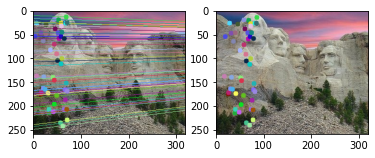

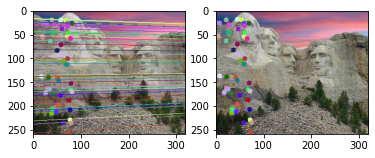

In [ ]:
img1 = cv2.imread('../images/Stereo Correspondence/1_1.jpg')  
img2 = cv2.imread('../images/Stereo Correspondence/1_2.jpg') 

draw_epilines(img1,img2,50)
draw_epilines(img2,img1,50)

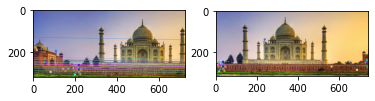

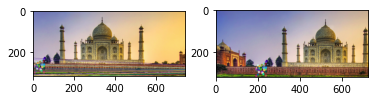

In [ ]:
img1 = cv2.imread('../images/Stereo Correspondence/2_1.png') 
img2 = cv2.imread('../images/Stereo Correspondence/2_2.png') 

draw_epilines(img1,img2,50)
draw_epilines(img2,img1,50)

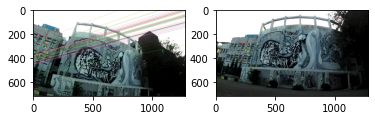

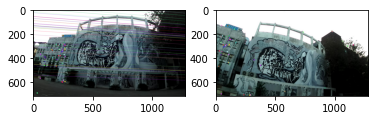

In [ ]:
img1 = cv2.imread('../images/Stereo Correspondence/3_1.jpg')  
img2 = cv2.imread('../images/Stereo Correspondence/3_2.jpg') 

draw_epilines(img1,img2,50)
draw_epilines(img2,img1,50)

## 1.3 Recitifiying the images

function    <font color=blue>__drawRecitifiedLines__</font>


 -  **Task** : Drawing the lines of corresponding points in each image
 -  **Working**: 
     - It iterates over the points and tgheir corresponding lines
     - Calculates the points value by substituting x value in ax+by+c=0 equation and then plotting the lines on the corresponding lines by connecting the calculated points
       
 -  **Input** : Points, images and lines
 -  **Output** : Lines plotted on the corresponding images

In [ ]:
def drawRecitifiedLines(pts1,pts2,linesOn1,linesOn2,img1,img2):
    for line1, line2, p1, p2 in zip(linesOn1[:100,:], linesOn2[:100,:], pts1[:100,:], pts2[:100,:]):

        rand_color = tuple(random.sample(range(0,256),3))
        
        Point1 = (0, int(-line1[2]/line1[1]))
        Point2 = (int(img1.shape[1]), int(-(line1[2]+line1[0]*img1.shape[1])/line1[1]))
        img1 = cv2.line(img1, Point1, Point2, rand_color, 1)
        img1 = cv2.circle(img1, tuple(p1), 5, rand_color, -1)

        Point1 = (0, int(-line2[2]/line2[1]))
        Point2 = (int(img2.shape[1]), int(-(line2[2]+line2[0]*img2.shape[1])/line2[1]))
        img2 = cv2.line(img2, Point1, Point2, rand_color, 1)
        img2 = cv2.circle(img2, tuple(p2), 5, rand_color, -1)
    
    return img1, img2

function    <font color=blue>__getRectImgs__</font>


 -  **Task** : Rectifying the given two images with respect to each other
 -  **Working**: Similar to draw_epilines function it will give get the points and then compute the corresponding epilines.
     - Apart from that it will calculate the error from the given points and the fundamental matrix
     - Using the corresponding homographies it will transform the image to other's image reference
 -  **Input** : two images
 -  **Output** : rectfied images, points and epilines

In [ ]:
def getRectImgs(img1, img2):
    
    sift = cv2.SIFT_create()

    kp1,des1 = sift.detectAndCompute(img1, None)
    kp2,des2 = sift.detectAndCompute(img2, None)
    
    pts1, pts2 = get_matches(kp1,kp2,des1,des2)
    
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    
    F, mask = get_fundamentalMatrixs(pts1,pts2)     
    
    linesOn1 = computeCorrespondEpilines(pts2,F.T)
    linesOn2 = computeCorrespondEpilines(pts1,F)

    img11 = np.copy(img1)
    img22 = np.copy(img2)

    img11,img22 = drawRecitifiedLines(pts1,pts2,linesOn1,linesOn2,img11,img22)
    
    retval, H1, H2 = cv2.stereoRectifyUncalibrated(pts1, pts2, F, imgSize=(img1.shape[1], img1.shape[0]))
    
    img1rectlines = cv2.warpPerspective(img11, H1, (img1.shape[1], img1.shape[0]))
    img2rectlines = cv2.warpPerspective(img22, H2, (img2.shape[1], img2.shape[0]))
    
    img1rect = cv2.warpPerspective(img1, H1, (img1.shape[1], img1.shape[0]))
    img2rect = cv2.warpPerspective(img2, H2, (img2.shape[1], img2.shape[0]))

    plt.imshow(img1rect)
    plt.show()
    
    plt.imshow(img1rectlines)
    plt.show()
    
    plt.imshow(img2rect)
    plt.show()
    
    plt.imshow(img2rectlines)
    plt.show()
    
    return img1rect, img2rect, linesOn1, linesOn2, pts1, pts2

### Finding the matches using greedy method

function    <font color=blue>__greedy_matching__</font>


 -  **Task** : Given rectified images and patch size
 -  **Working**: Takes rectfied images and patch size
             - This will loop over every point and it's corresponding line in other image
             - For every point consider a patch around it and then along the same row in the otehr rectified images use the ptaches along the line and find the correlation. 
             - Whichever gives more correlation draw a line between that patch to the maximum correlated patch
             - repeat this for every point
 -  **Input** : rectified images and points 
 -  **Output**: Images with lines connecting the maximum correlated patches in rectified images

In [ ]:
def greedy_matching(img1, img2,m,points):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)

    concatimg = np.concatenate((img1, img2[0:img1.shape[0],:]), axis=1)

    pts1 = np.int32(cv2.KeyPoint_convert(kp1))

    indices = np.random.randint(low=0, high=pts1.shape[0], size=points)

    for i in indices:
        x1,y1 = pts1[i][0], pts1[i][1]
        patch1 = img1[ max(x1-m//2, 0) : min(x1+m//2, img1.shape[1]), max(y1-m//2, 0) : min(y1+m//2, img1.shape[0]) ].flatten()
        rand_color = tuple(random.sample(range(0,256),3))
        x2,y2 = -1, y1
        greatestcorr = -1
        for j in range(0, img2.shape[1], m//4):
            patch2 = img2[j : j+m, max(y1-m//2, 0) : min(y1+m//2, img2.shape[0])].flatten()
            if patch1.shape==patch2.shape:
                curcorr = np.corrcoef(patch1, patch2)[0][1]
                if curcorr > greatestcorr:
                    greatestcorr = curcorr
                    x2 = j + m//2 + img1.shape[1]
                    
        if greatestcorr!=-1:
            concatimg = cv2.line(concatimg, (x1,y1), (x2,y2), rand_color, 1)
            concatimg = cv2.circle(concatimg, (x1,y1), 5, rand_color, -1)
            concatimg = cv2.circle(concatimg, (x2,y2), 5, rand_color, -1)

    return concatimg

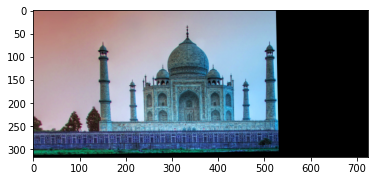

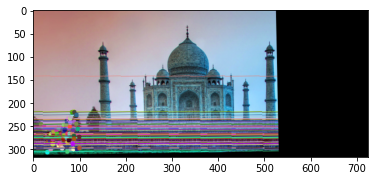

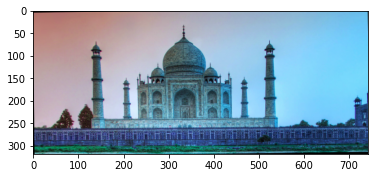

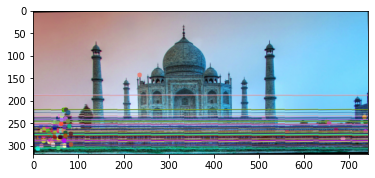

In [ ]:
img1 = cv2.imread('../images/Stereo Correspondence/2_1.png')  
img2 = cv2.imread('../images/Stereo Correspondence/2_2.png')

rec1, rec2, lines1, lines2,pts1,pts2 = getRectImgs(img1,img2)

/home/likhitha/anaconda3/envs/CV/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/likhitha/anaconda3/envs/CV/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


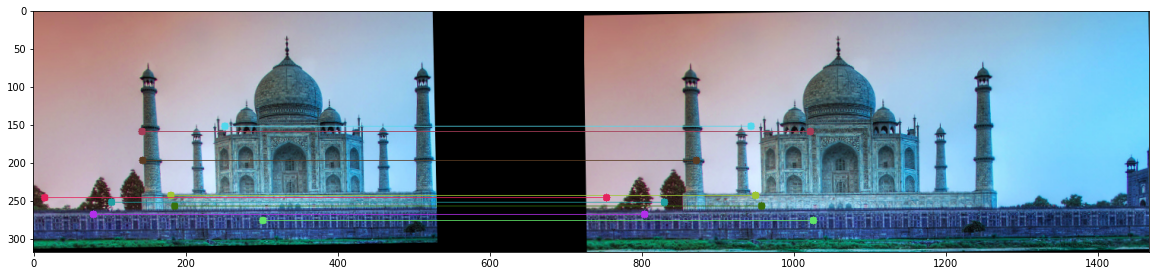

In [ ]:
result = greedy_matching(rec1, rec2,10,20)

plt.figure(figsize=(20,20))
plt.imshow(result)
plt.show()

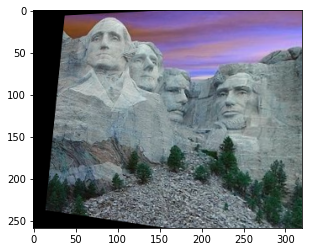

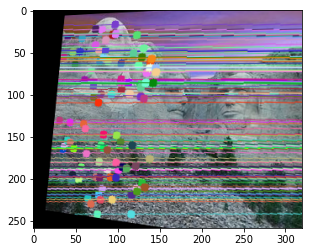

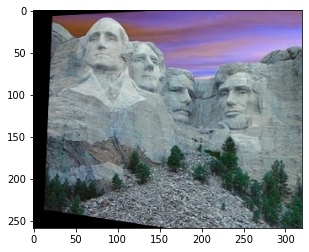

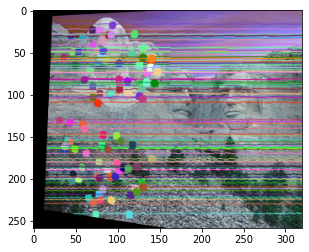

In [ ]:
img1 = cv2.imread('../images/Stereo Correspondence/1_1.jpg') 
img2 = cv2.imread('../images/Stereo Correspondence/1_2.jpg') 

rec1, rec2, lines1, lines2,pts1,pts2 = getRectImgs(img1,img2)

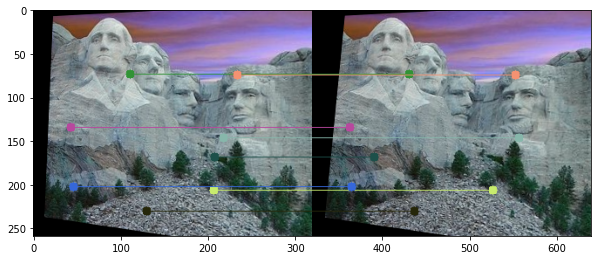

In [ ]:
result = greedy_matching(rec2, rec1,10,10)

plt.figure(figsize=(10,10))
plt.imshow(result)
plt.show()

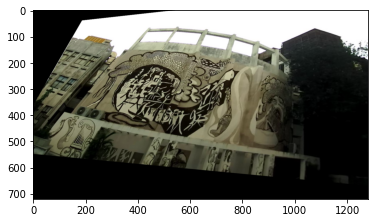

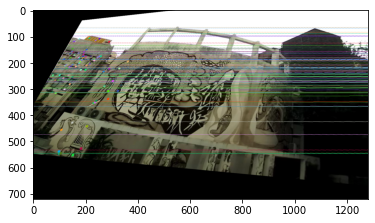

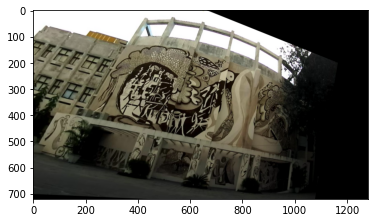

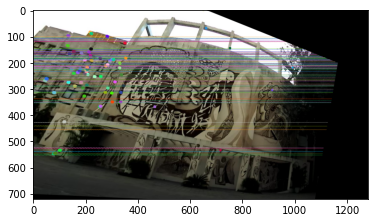

In [ ]:
img1 = cv2.imread('../images/Stereo Correspondence/3_1.jpg') 
img2 = cv2.imread('../images/Stereo Correspondence/3_2.jpg') 

rec1, rec2, lines1, lines2,pts1,pts2 = getRectImgs(img1,img2)

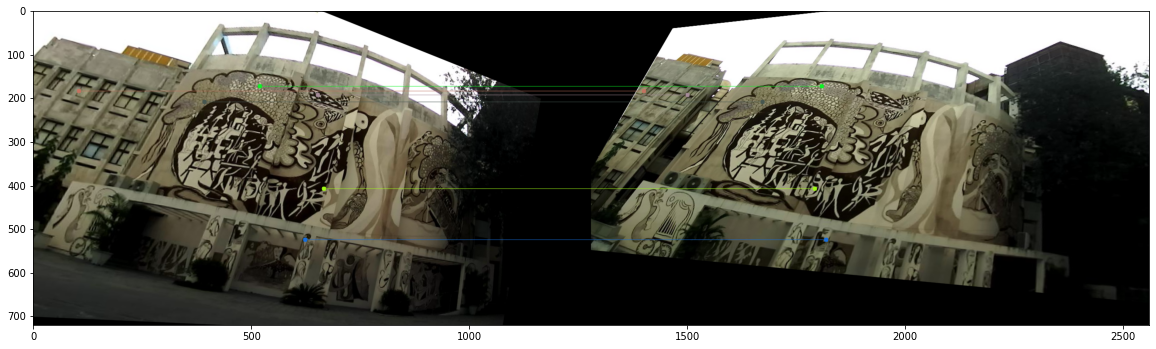

In [ ]:
result = greedy_matching(rec2, rec1,10,10)

plt.figure(figsize=(20,20))
plt.imshow(result)
plt.show()

## 1.4 Comparing Brute force and Greedy method

__Brute force method__:

- This is computationally expensive as we have to comapre with every patch
- If more than one patch has same correlation, there might be a fare chance of getting a match with wrong patch

__Greedy method__:

- This is comapratively computationally less expensive as we only need to check for patches around the epilines of that particular point
- Comapratively there is very less chance of getting matched with wrong patch
- When all the patches along the epiline has same intensity then this might result in a wrong patch

## 1.5 Dense SIFT matching 

- In this we have to consider every pixel as one patch 
- So the patch size for performing intensity window based correlation is 1x1
- if we call get_points(img1,img2,m) function defined above with m=1 we get Dense SIFT matching
- As this takes lot of time I'm not performing it
- I tried to do it but system didn't support the computation. Resulted in kernel dead
- The idea of dense is to perform pixel to pixel matching